Note: This notebook is inspired by: [GitHub Repository](https://github.com/aangelopoulos/conformal-prediction/blob/main/notebooks/meps-cqr.ipynb)

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
!pip install -U --no-cache-dir gdown --pre

np.random.seed(42)

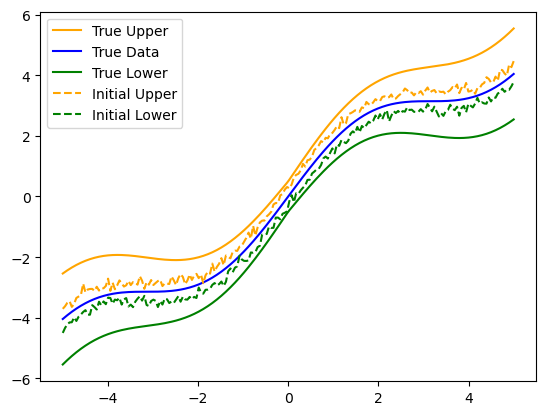

In [11]:
np.random.seed(42)
def mu(x):
    return np.sin(x) + x

def sigma(x):
    return 0.2 * np.abs(x) + 0.5

n_lin = 200
x_lin = np.linspace(-5, 5, n_lin)
y_upper = mu(x_lin) + sigma(x_lin)
y_true = mu(x_lin)
y_lower = mu(x_lin) - sigma(x_lin)
initial_upper = y_true + np.random.normal(0, 0.1, len(x_lin)) + 0.3
initial_lower = y_true + np.random.normal(0, 0.1, len(x_lin)) - 0.3

plt.plot(x_lin, y_upper, label='True Upper', color='orange')
plt.plot(x_lin, y_true, label='True Data', color='blue')
plt.plot(x_lin, y_lower, label='True Lower', color='green')
plt.plot(x_lin, initial_upper, label='Initial Upper', color='orange', linestyle='--')
plt.plot(x_lin, initial_lower, label='Initial Lower', color='green', linestyle='--')
plt.legend()
plt.show()

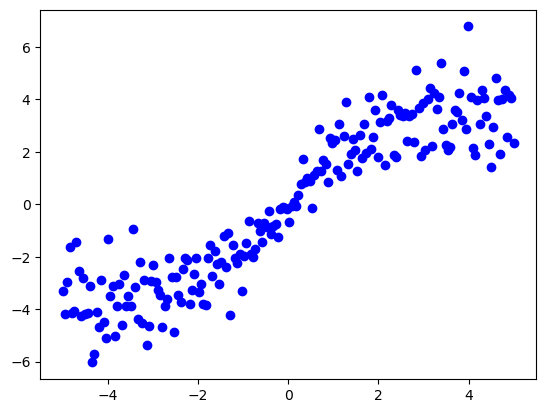

In [12]:
# generate data having mu coming from function mu(x) and sigma coming from function sigma(x)
np.random.seed(42)
given_data = np.random.normal(mu(x_lin), sigma(x_lin), n_lin)
plt.scatter(x_lin, given_data, color='blue')
plt.show()

In [ ]:
from typing import Tuple

import numpy as np
import scipy
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

from mapie._typing import NDArray
from mapie.regression import MapieQuantileRegressor, MapieRegressor
from mapie.subsample import Subsample

random_state = 42

In [ ]:
polyn_model = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=4)),
        ("linear", LinearRegression()),
    ]
)
polyn_model_quant = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=4)),
        ("linear", QuantileRegressor(
            solver="highs-ds",
            alpha=0,
        )),
    ]
)
mapie = MapieQuantileRegressor(  # type: ignore
        polyn_model_quant,
        **params
    )
mapie.fit(X_train.reshape(-1, 1), y_train, random_state=random_state)
y_pred, y_pis = mapie.predict(X_test.reshape(-1, 1))

In [3]:
# Problem setup
n=10         # number of calibration points
alpha = 0.1     # 1-alpha is the desired coverage
cal_upper = np.array([4., 4., 5., 2.5, 2., 6., 4., 7.5, 10., 11.])
cal_labels= np.array([2., 3., 4., 3., 3., 4., 5., 7., 9., 10.])
cal_lower = np.array([6., 2., 2., 2., 4., 5., 4.5, 8., 8., 10.])

# Step 1: calculate the scores for the calibration set
cal_scores = np.maximum(cal_labels - cal_upper, cal_lower - cal_labels)
print("np.sorted(cal_scores): ", np.sort(cal_scores))

# Step 2: calculate the quantile
q_level = np.ceil((n+1)*(1-alpha))/n
qhat = np.quantile(cal_scores, q_level, method='higher')
print(f'qhat: {qhat}')

# Step 3: calculate the prediction sets - for the validation set - by adjusting the initial values
print("Before Upper:  ", cal_upper)
print("Before Labels: ", cal_labels)
print("Before Lower:  ", cal_lower)
print("Updated Upper: ", cal_upper + qhat)
print("Updated Labels:", cal_labels)
print("Updated Lower: ", cal_lower - qhat)

np.sorted(cal_scores):  [-1.  -1.  -1.   0.   0.5  1.   1.   1.   1.   4. ]
qhat: 4.0
Before Upper:   [ 4.   4.   5.   2.5  2.   6.   4.   7.5 10.  11. ]
Before Labels:  [ 2.  3.  4.  3.  3.  4.  5.  7.  9. 10.]
Before Lower:   [ 6.   2.   2.   2.   4.   5.   4.5  8.   8.  10. ]
Updated Upper:  [ 8.   8.   9.   6.5  6.  10.   8.  11.5 14.  15. ]
Updated Labels: [ 2.  3.  4.  3.  3.  4.  5.  7.  9. 10.]
Updated Lower:  [ 2.  -2.  -2.  -2.   0.   1.   0.5  4.   4.   6. ]


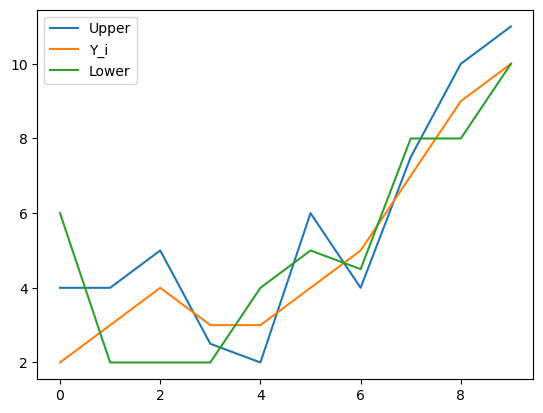

In [9]:
plt.plot(cal_upper, label='Upper')
plt.plot(cal_labels, label='Y_i')
plt.plot(cal_lower, label='Lower')
plt.legend()
plt.show()

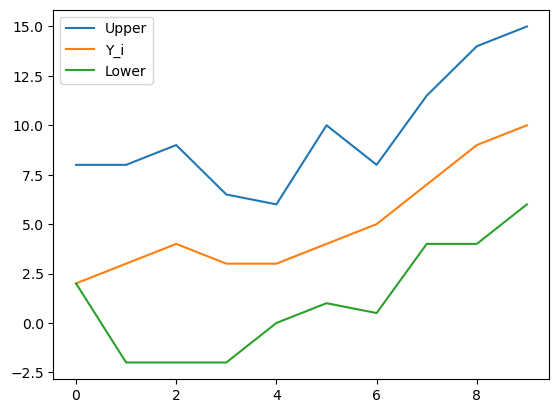

In [8]:
plt.plot(cal_upper + qhat, label='Upper')
plt.plot(cal_labels, label='Y_i')
plt.plot(cal_lower - qhat, label='Lower')
plt.legend()
plt.show()